In [2]:
# Own Libraries
from utils.data import load_data
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms
# 3rd Party Libraries
from skimage.io import imread
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
"""
   Plot 1st Query Results
"""   
def plot_image_and_similar(qs,top_qs) -> None:
    
    for i in range(len(qs)):
        f, axarr = plt.subplots(1,2, figsize=(10,10))
        base = qs[i]
        print(top_qs[i])
        query = imread(top_qs[i][0])
        axarr[0].imshow(base)
        axarr[0].title.set_text("Base")
        axarr[1].imshow(query)
        axarr[1].title.set_text("Query")
        plt.show()


In [4]:
# Load Data
db, db_files = load_data("./data/BBDD/",".jpg", desc = "Loading BBDD Data...")
qsd2_w1, qsd2_w1_files = load_data("./data/qsd2_w1/",".jpg", desc = "Loading qsd2_w1 Data...")
qsd1_w2, qsd1_w2_files = load_data("./data/qsd1_w2/",".jpg", desc = "Loading qsd1_w2 Data...")
qsd2_w2, qsd2_w2_files = load_data("./data/qsd2_w2/",".jpg", desc = "Loading qsd2_w2 Data...")

# 3D Normalized Histograms Multiresolutio/Block Images
db_feature_matrix = calculate_histograms(db,16,n_rows=4,n_cols=4,desc="Normalized 3D Histograms Calculation for BBDD...")
qsd2_w1_feature_matrix = calculate_histograms(qsd2_w1,16,n_rows=4,n_cols=4,desc = "Normalized 3D Histograms Calculation for qsd2_w1...")
qsd1_w2_feature_matrix = calculate_histograms(qsd1_w2,16,n_rows=4,n_cols=4,desc = "Normalized 3D Histograms Calculation for qsd1_w2...")
qsd2_w2_feature_matrix = calculate_histograms(qsd2_w2,16,n_rows=4,n_cols=4,desc = "Normalized 3D Histograms Calculation for qsd2_w2...")

# Similarity
sim = Similarity()
qs2_w1_similarities = sim.compute_similarities(qs = qsd2_w1_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w1 similarities...", similarity = 'hellinger')
qs1_w2_similarities = sim.compute_similarities(qs = qsd1_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd1_w2 similarities...", similarity = 'hellinger')
qs2_w2_similarities = sim.compute_similarities(qs = qsd2_w2_feature_matrix, db_feature_matrix = db_feature_matrix, desc = "Computing qsd2_w2 similarities...", similarity = 'hellinger')

# Get top K
top_k_qsd2_w1 = get_top_k(similarity_matrix=qs2_w1_similarities,k=1,files=db_files,desc="Retrieving qsd2_w1 top K similar images...")
top_k_qsd1_w2 = get_top_k(similarity_matrix=qs1_w2_similarities,k=1,files=db_files,desc="Retrieving qsd1_w2 top K similar images...")
top_k_qsd2_w2 = get_top_k(similarity_matrix=qs2_w2_similarities,k=1,files=db_files,desc="Retrieving qsd2_w2 top K similar images...")

Loading BBDD Data...: 100%|██████████| 287/287 [00:17<00:00, 16.26it/s]


./data/BBDD/ read: 287 images


Loading qsd2_w1 Data...: 100%|██████████| 30/30 [00:00<00:00, 85.17it/s]


./data/qsd2_w1/ read: 30 images


Loading qsd1_w2 Data...: 100%|██████████| 30/30 [00:00<00:00, 70.39it/s]


./data/qsd1_w2/ read: 30 images


Loading qsd2_w2 Data...: 100%|██████████| 30/30 [00:02<00:00, 14.98it/s]


./data/qsd2_w2/ read: 30 images


Normalized 3D Histograms Calculation for BBDD...: 100%|██████████| 287/287 [00:05<00:00, 55.65it/s]
Normalized 3D Histograms Calculation for qsd2_w1...: 100%|██████████| 30/30 [00:00<00:00, 101.75it/s]
Normalized 3D Histograms Calculation for qsd1_w2...: 100%|██████████| 30/30 [00:00<00:00, 144.72it/s]
Normalized 3D Histograms Calculation for qsd2_w2...: 100%|██████████| 30/30 [00:00<00:00, 43.37it/s]
Computing qsd2_w2 similarities...: 100%|██████████| 30/30 [00:00<00:00, 35.99it/s]


NameError: name 'get_top_k' is not defined

['./data/BBDD/bbdd_00001.jpg']


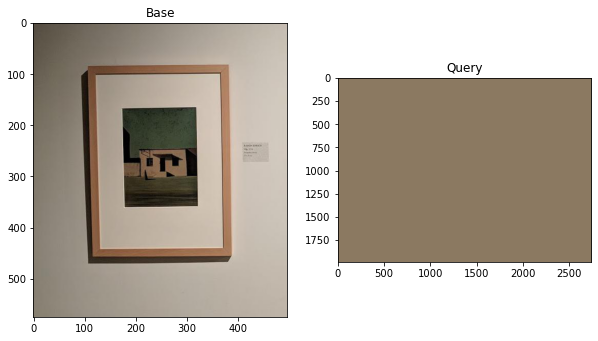

['./data/BBDD/bbdd_00001.jpg']


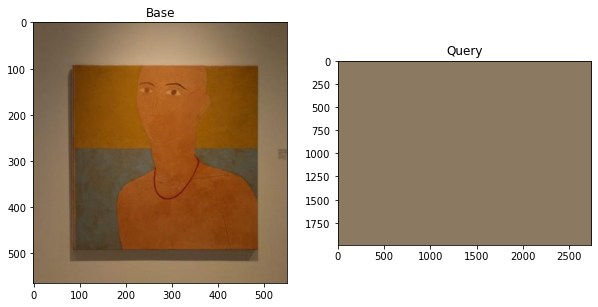

['./data/BBDD/bbdd_00001.jpg']


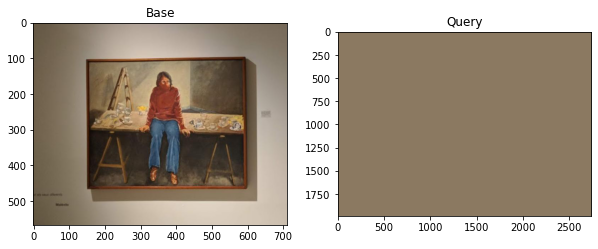

['./data/BBDD/bbdd_00001.jpg']


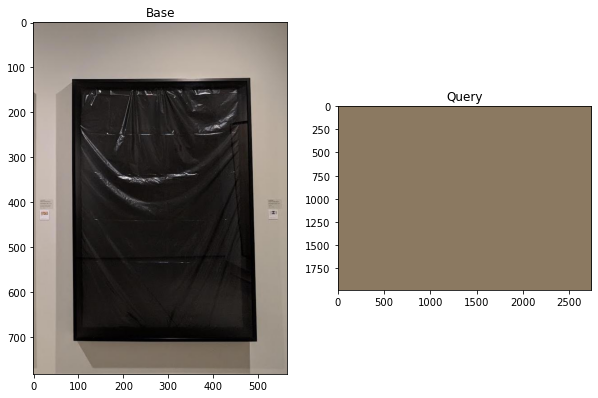

['./data/BBDD/bbdd_00001.jpg']


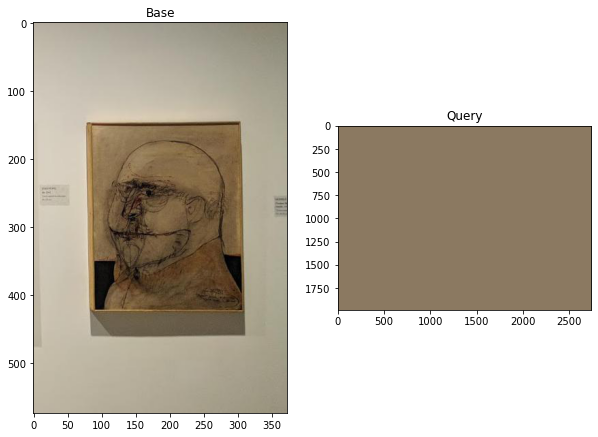

['./data/BBDD/bbdd_00001.jpg']


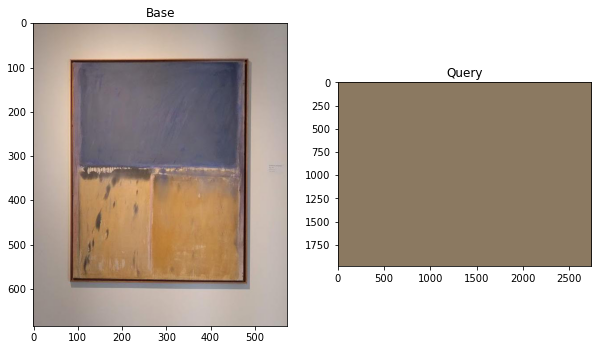

['./data/BBDD/bbdd_00001.jpg']


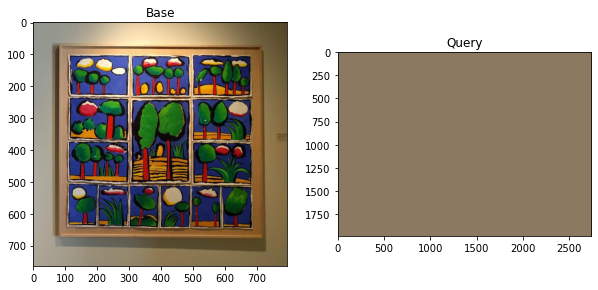

['./data/BBDD/bbdd_00001.jpg']


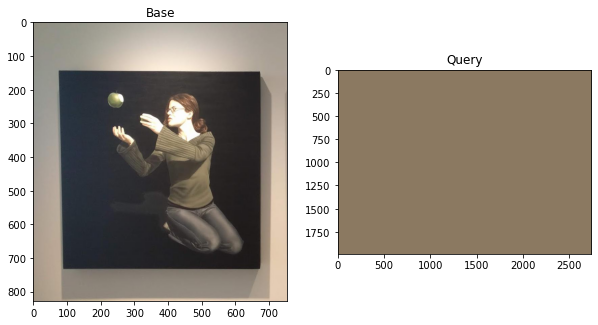

['./data/BBDD/bbdd_00001.jpg']


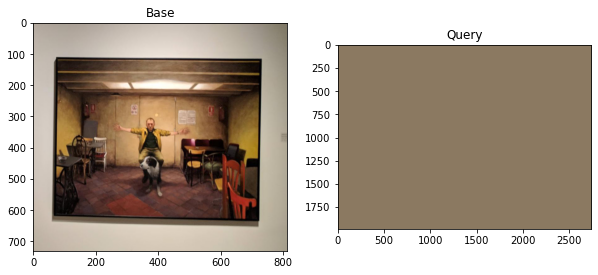

['./data/BBDD/bbdd_00001.jpg']


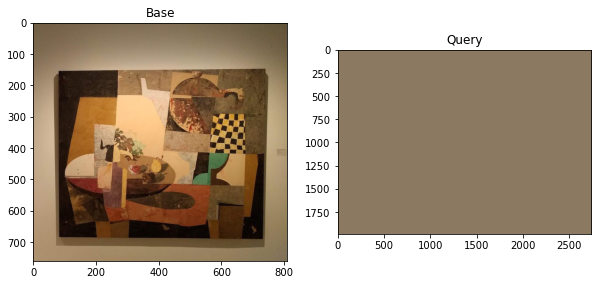

['./data/BBDD/bbdd_00001.jpg']


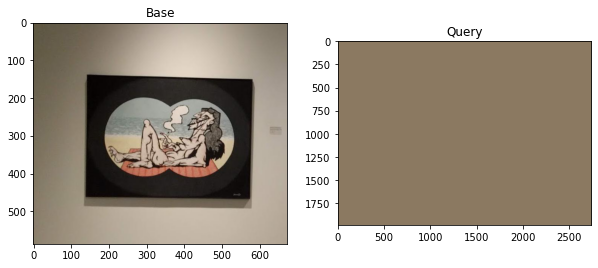

['./data/BBDD/bbdd_00001.jpg']


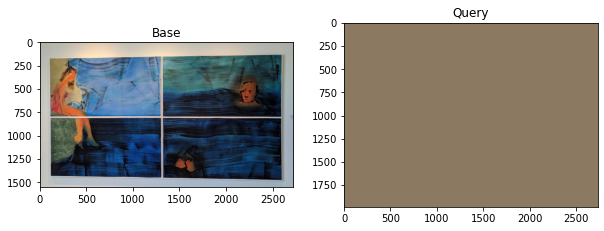

['./data/BBDD/bbdd_00001.jpg']


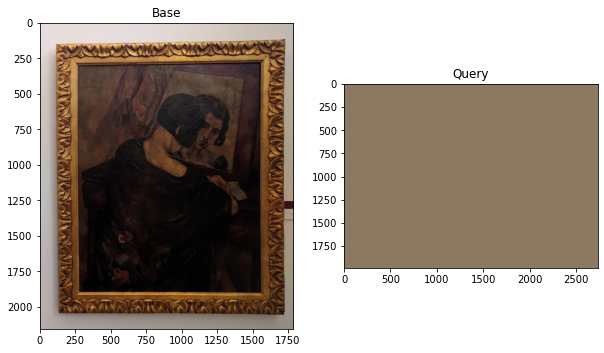

['./data/BBDD/bbdd_00001.jpg']


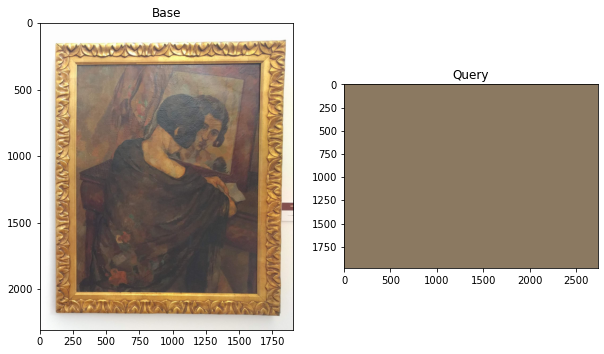

['./data/BBDD/bbdd_00001.jpg']


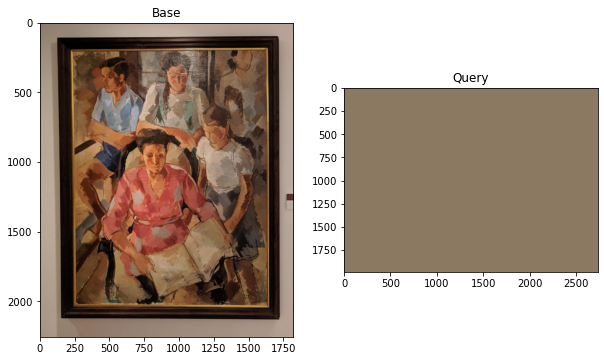

['./data/BBDD/bbdd_00001.jpg']


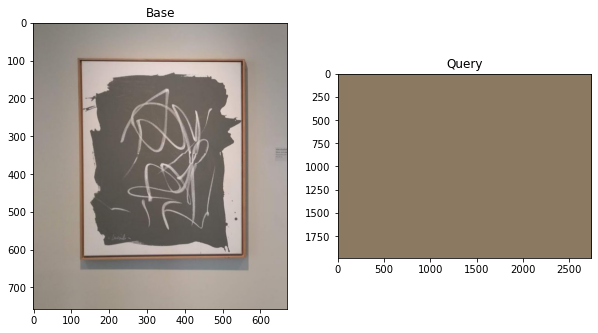

['./data/BBDD/bbdd_00001.jpg']


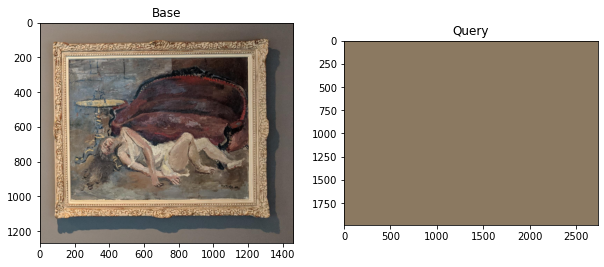

['./data/BBDD/bbdd_00001.jpg']


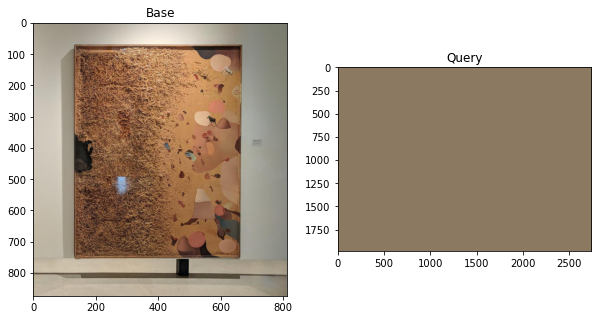

['./data/BBDD/bbdd_00001.jpg']


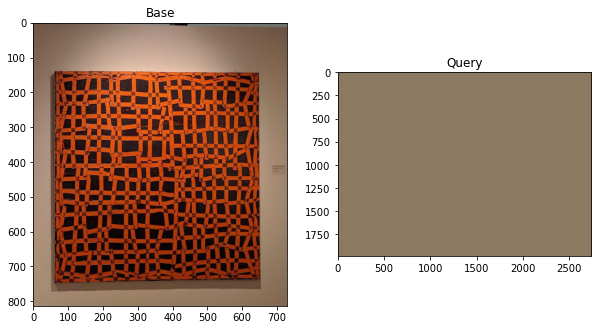

['./data/BBDD/bbdd_00001.jpg']


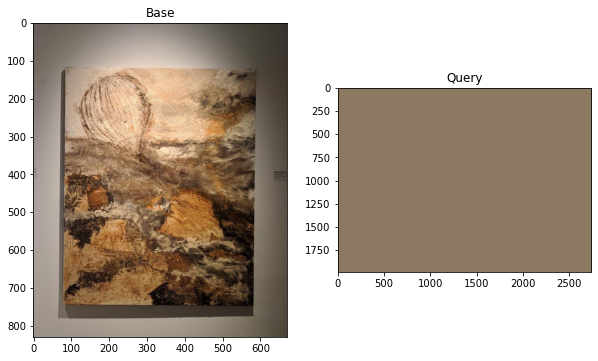

['./data/BBDD/bbdd_00001.jpg']


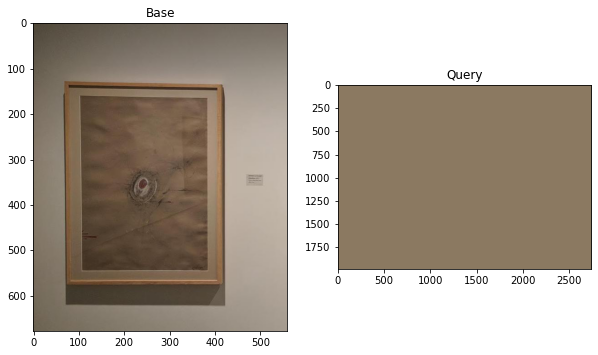

['./data/BBDD/bbdd_00001.jpg']


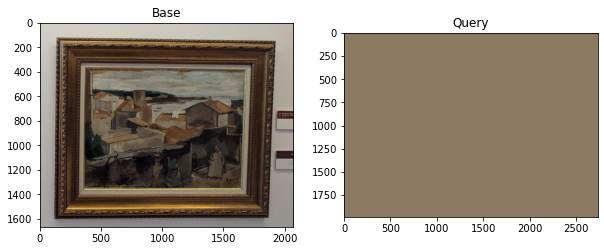

['./data/BBDD/bbdd_00001.jpg']


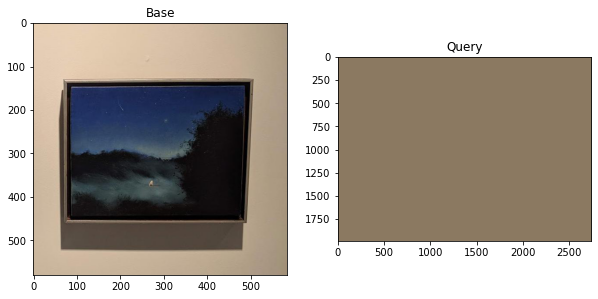

['./data/BBDD/bbdd_00001.jpg']


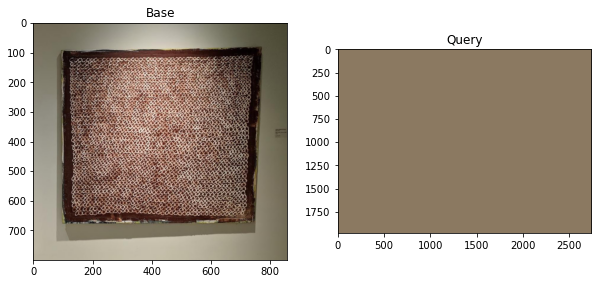

['./data/BBDD/bbdd_00001.jpg']


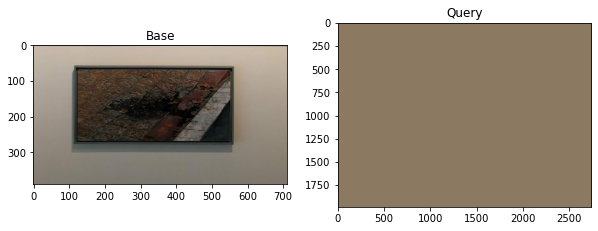

['./data/BBDD/bbdd_00001.jpg']


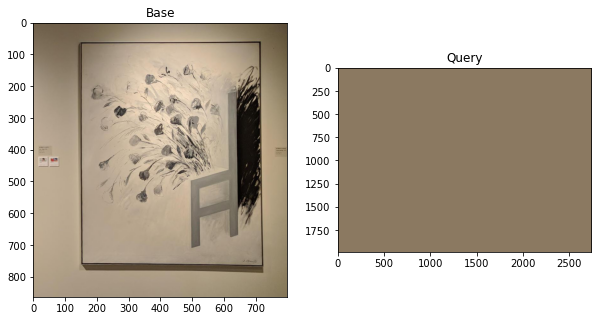

['./data/BBDD/bbdd_00001.jpg']


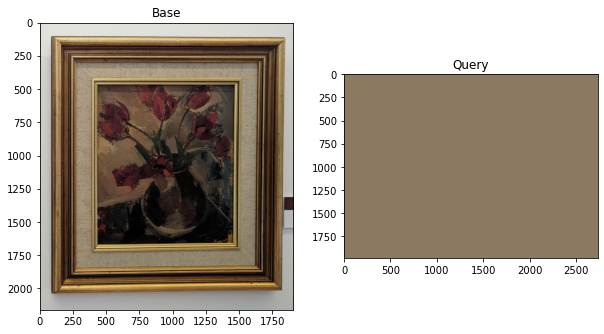

['./data/BBDD/bbdd_00001.jpg']


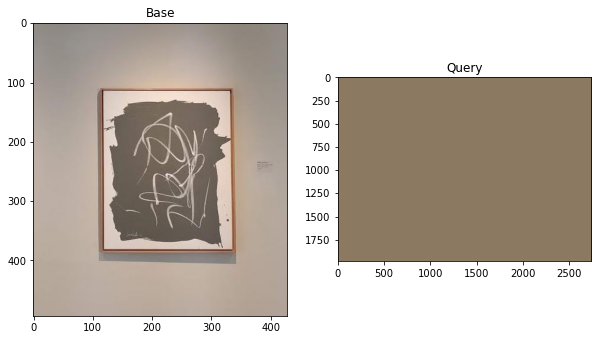

['./data/BBDD/bbdd_00001.jpg']


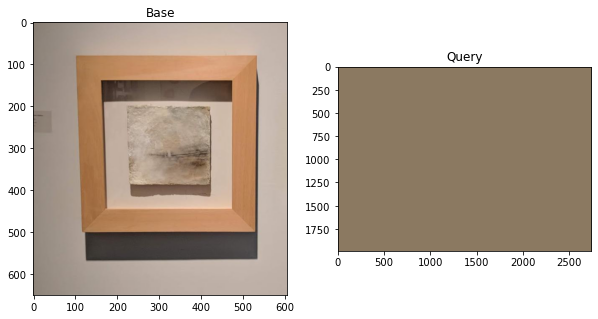

['./data/BBDD/bbdd_00001.jpg']


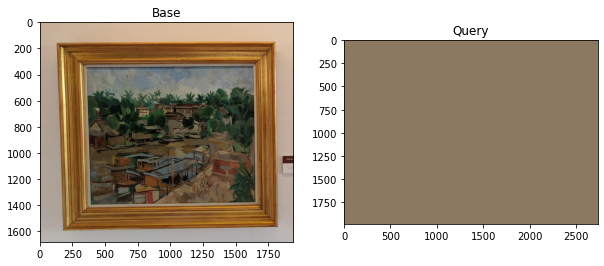

In [34]:
plot_image_and_similar(qsd2_w1,top_k_qsd2_w1)

In [ ]:
def plot_image_and_windows(images: np.ndarray, n_cols: int, n_rows: int) -> None:
    for im in images:
        windows = image_to_windows(im, n_cols=n_cols, n_rows=n_rows)
        f, axarr = plt.subplots(4,4, figsize=(15,15))
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i,j].imshow(windows[j+i*n_rows])
                
        plt.savefig('tmp.png')
        plt.clf() 
        f, axarr = plt.subplots(1,2, figsize=(15,15))
        windows = imread('tmp.png')
        axarr[0].imshow(windows)
        axarr[1].imshow(im)
        plt.show()
        os.remove('tmp.png')
        
        
plot_image_and_windows(db[:2], 4, 4)